
# Deep Neural Networks, Representation Learning, and Text Analytics</span>


## <span style="color:#0b486b">Part 1: Deep Feedforward Neural Network </span>


In [192]:
import os
if not os.path.exists("./models/dnn0"):
    os.makedirs("models/dnn0")

Applying DNN to recognize letters from A-Z. \

Here I am going to work with the **notMNIST** dataset for *letter recognition task*. The dataset contains 10 classes of letters A-J taken from different fonts. You will see some examples at the visualization task in the next part. A short blog about the data can be found [here](http://yaroslavvb.blogspot.com.au/2011/09/notmnist-dataset.html).

Here we only consider a small subset which can be found at [this link](http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat).

####  </span> Loading the data into *`numpy array`* format of two variables:
* *`x`*: storing features with dimension `[num_samples, width, height]` (`num_samples`: number of samples, `width`: image width, `height`: image height), and
* *`y`*: storing labels with dimension `num_samples`. 
<div style="text-align: right"><span style="color:red"></span></div>


In [193]:
import numpy as np
import scipy.io as sio
data = sio.matlab.loadmat("datasets/notMNIST_small.mat")

x, y = data['images'],data['labels']

x = np.rollaxis(x, axis=2)

####  </span> Printing out the total number of data points, and the *unique* labels in this dataset.
<div style="text-align: right"><span style="color:red"></span></div> 

In [194]:
#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL
labels = np.unique(y)
num_samples = len(x)
print('Total no. of sample images are',num_samples)
print('unique labels are', labels)

Total no. of sample images are 18724
unique labels are [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


#### </span>Displaying 100  images in the form of `10x10` matrix, each row showing 10 *random* images of a label.
<div style="text-align: right"><span style="color:red"></span></div> 

In [195]:
# this function is a utility to display images from the dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_images(images, shape):
    fig = plt.figure(figsize=shape)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(np.prod(shape)):
        p = fig.add_subplot(shape[0], shape[1], i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)                

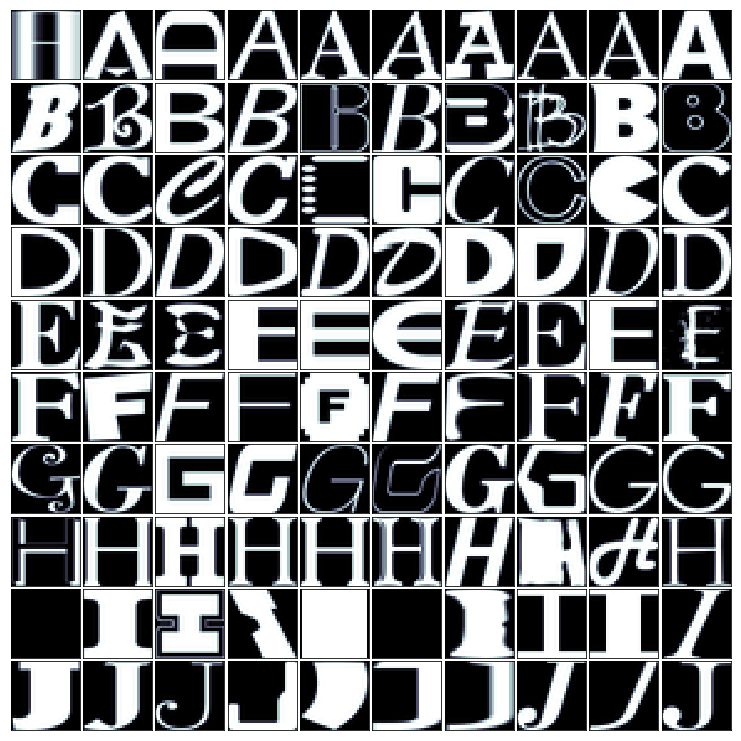

In [196]:
unique_labels = labels
images = []
for l in unique_labels:    
    idx = np.where(y == l)[0]
    idx = idx[np.random.permutation(len(idx))[:10]] 
    for i in idx:
        images += [x[i]]

display_images(images, shape=(10, 10))

####  </span>Using the *deep feedforward neural network* as the classifier to perform images classification task in a *single split training and testing*.

<span style="color:red">**(a)**</span> **Writing the code to reshape the variable `x` storing features from `[num_samples, width, height]` dimension to `[num_samples, num_features]` with `num_features = width x height`. **
<div style="text-align: right"> <span style="color:red"></span> </div>

In [197]:
image_height = len(x[1])
image_width = len(x[1][1])

features = []

for i in range(num_samples):
    features = features+[np.reshape(x[i],image_height * image_width)]

In training the DNN, scaling data is important. The pixel intensities of images are in the range of [0, 255], which makes the neural network difficult to learn.

**Rescaling the input data into the range of [0, 1]**
<div style="text-align: right"> 
<span style="color:red"></span> </div>

In [198]:
X = []

for i in features:
    X = X + [[j/255 for j in i]]
X = np.array(X)

<span style="color:red">**(b)**</span> **Splitting the data into two subsets: 70% for training and 30% for testing. Using [*Stratified-Shuffle-Split*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to make sure training and testing are balanced and randomly shuffled before learning the model.**
<div style="text-align: right"> <span style="color:red"></span> </div>

In [200]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

<span style="color:red">**(c)**</span> **Constructing a deep feedforward neural network with the following architecture:**

* An input layer followed by *two* hidden layers, each with *500* hidden units, and an *output* layer;
* *ReLU* activations for neurons in each hidden layer;
* Training with gradient descent optimizer with learning rate **0.0011**, batch size 128 and 50 epochs.

<div style="text-align: right"> <span style="color:red"></span> </div>

In [201]:
import tensorflow as tf

tf.reset_default_graph()

num_inputs = 28*28
num_hidden1 = 500
num_hidden2 = 500
num_outputs = len(np.unique(y))

x = tf.placeholder(tf.float32, shape=[None, num_inputs], name='X')
y = tf.placeholder(tf.int64, shape=[None], name='y')

In [202]:
def neuron_layer(x, num_neurons, name, activation=None):
    with tf.name_scope(name):
        num_inputs = int(x.get_shape()[1])
        stddev = 2 / np.sqrt(num_inputs)
        init = tf.truncated_normal([num_inputs, num_neurons], stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([num_neurons]), name="biases")
        z = tf.matmul(x, W) + b
    if activation == "sigmoid":
        return tf.nn.sigmoid(z)
    elif activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

In [203]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(x, num_hidden1, "hidden1", activation="relu")     
    hidden2 = neuron_layer(hidden1, num_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, num_outputs, "output")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("evaluation"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


    
with tf.name_scope("train"):
    learning_rate = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(loss) 
    training_op = optimizer.minimize(loss)
    
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name + "/values", var)
        
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + "/gradients", grad)

# summary
accuracy_summary = tf.summary.scalar('accuracy', accuracy)


In [204]:
# merge all summary
tf.summary.histogram('hidden1/activations', hidden1)
tf.summary.histogram('hidden2/activations', hidden2)
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_writer = tf.summary.FileWriter("models/dnn0/train", tf.get_default_graph())
test_writer = tf.summary.FileWriter("models/dnn0/test", tf.get_default_graph())

num_epochs = 50
batch_size = 128

In [205]:
X_train.shape

(13106, 784)

<span style="color:red">**(d)**</span> **Training the DNN.** Writing codes in the following cell. <span style="color:red"></span> </div>

In [206]:
with tf.Session() as sess:
    init.run()
    print("Epoch\tTrain accuracy\tTest accuracy")
    for epoch in range(num_epochs):
        for idx_start in range(0, X_train.shape[0], batch_size):
            idx_end = idx_start + batch_size      
            x_batch, y_batch = X_train[idx_start:idx_end], y_train[idx_start:idx_end]   
            sess.run(training_op, feed_dict={x: x_batch, y: y_batch})
            
        summary_train, acc_train = sess.run([merged, accuracy],feed_dict={x: x_batch, y: y_batch})
        summary_test, acc_test =  sess.run([accuracy_summary, accuracy],feed_dict={x: X_test, y: y_test})
        
        train_writer.add_summary(summary_train, epoch)
        test_writer.add_summary(summary_test, epoch)
        
        print("{}\t{}\t{}".format(epoch, acc_train, acc_test))

    save_path = saver.save(sess, "models/dnn0.ckpt")

Epoch	Train accuracy	Test accuracy
0	0.8999999761581421	0.8380206227302551
1	0.9200000166893005	0.861516535282135
2	0.9200000166893005	0.871128499507904
3	0.9399999976158142	0.876290500164032
4	0.9399999976158142	0.880028486251831
5	0.9399999976158142	0.8841224908828735
6	0.9399999976158142	0.8866144418716431
7	0.9599999785423279	0.8896404504776001
8	0.9599999785423279	0.8915984630584717
9	0.9599999785423279	0.8933784365653992
10	0.9599999785423279	0.8942683935165405
11	0.9800000190734863	0.8956924080848694
12	0.9800000190734863	0.8960484266281128
13	0.9800000190734863	0.8974723815917969
14	1.0	0.8980063796043396
15	1.0	0.8981844186782837
16	1.0	0.899074375629425
17	1.0	0.8997864127159119
18	1.0	0.9008544087409973
19	1.0	0.9019224047660828
20	1.0	0.9022783637046814
21	1.0	0.9028123617172241
22	1.0	0.9026343822479248
23	1.0	0.9026343822479248
24	1.0	0.9029904007911682
25	1.0	0.9029904007911682
26	1.0	0.9040583968162537
27	1.0	0.9044143557548523
28	1.0	0.9047703742980957
29	1.0	0.9049483

---

## <span style="color:#0b486b">Part 2: Word2Vec, Text Analytics and Application</span>
<div style="text-align: right"><span style="color:red"><span></div>


In this part, I am going to use Word2Vec for document classification on [20 Newsgroups](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html) dataset. This dataset is a collection of messages collected from 20 different netnews newsgroups. One thousand messages from each of the twenty newsgroups were chosen at random and partitioned by newsgroup name. The list of newsgroups from which the messages were chosen is as follows:

`
alt.atheism
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc
soc.religion.christian
comp.sys.ibm.pc.hardware
comp.graphics
comp.os.ms-windows.misc
comp.sys.mac.hardware
comp.windows.x
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.space
sci.med
misc.forsale
`

### <span style="color:#0b486b"> Download the dataset and data pre-processing</span>

####  <span style="color:red"></span> Downloading the dataset.

<div style="text-align: right"><span style="color:red"></span></div> 

In [207]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers'))

####  <span style="color:red"></span>Printing out the total number of documents, and the *unique* labels in this dataset.
<div style="text-align: right"><span style="color:red"></span></div> 

In [208]:
import numpy as np

data = newsgroups_all.data
label = newsgroups_all.target
print('Total number of documents are:',len(data))
print('Unique labels:', np.unique(label) )

Total number of documents are: 18846
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


####  <span style="color:red"></span>Convert the documents into a list of tokens using the function `gensim.utils.tokenize`.
<div style="text-align: right"><span style="color:red"></span></div>


In [209]:
import gensim

#list(gensim.utils.tokenize(data[1]))
tokens = [list(gensim.utils.tokenize(i)) for i in data]

### <span style="color:#0b486b"> Training the model </span>


####  <span style="color:red"></span>Training gensim's word2vec model.
<div style="text-align: right"><span style="color:red"></span></div>

* Training gensim's word2vec model with the settings of:
    * The dimensionality of the feature vectors: `size=100`,
    * The maximum distance between the current and predicted word within a sentence: `window=5`,
    * Minimum frequence (ignore all words with total frequency lower than this): `min_count=5`,


In [211]:
from gensim.models import Word2Vec

model = Word2Vec(tokens, size=100, window=5, min_count=5)

* Save the trained model to a file named "20_newsgroups.gensim"

In [212]:
model.save("20_newsgroups.gensim")

C:\Users\HP\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


####  <span style="color:red"></span>Printing out the vocabulary size (number of words in vocabulary).
<div style="text-align: right"><span style="color:red"></span></div> 

In [213]:
words = list(model.wv.vocab.keys())
print('Vocabulary size:', len(words))

Vocabulary size: 42461


####  <span style="color:red"></span>Using the embedding results, calculating and printing out the ten most similar words to word 'law' and their corresponding similarity scores.<div style="text-align: right"><span style="color:red"></span></div> 

In [214]:
model.wv.most_similar('law')

[('laws', 0.7431665658950806),
 ('court', 0.7381443381309509),
 ('enforcement', 0.7273108959197998),
 ('government', 0.7127928733825684),
 ('federal', 0.6847028732299805),
 ('legal', 0.6804093718528748),
 ('authority', 0.6772668361663818),
 ('authorities', 0.6671850681304932),
 ('justice', 0.6615682244300842),
 ('marshalls', 0.6614121198654175)]

### <span style="color:#0b486b"> Evaluating the embeddings using classification </span>

Investigating the quality of embedded vectors via document classification task. We have learned the embeddings for words, but not for documents yet, thus we need to find a way to extract the document embeddings from word embeddings. We are going to try two approaches:
* Taking the **sum** of vectors of all words in the document; or
* Taking the **average** of vectors of all words in the document.

####  <span style="color:red"></span>Extracting document vectors using `sum`.
<div style="text-align: right"><span style="color:red"></span></div> 

* Removing all ***empty*** documents. A document is empty if it does not contain any word in the vocabulary;
* Extracting document vectors and save to variable `x`;
* Saving the corresponding labels to variable `y`.

In [215]:
x=[]
y=[]

def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).sum(axis=0)
    return vecs
for i in range(len(tokens)):
    if(list(extract_doc2vec(tokens[i], model))):
        x = x + [list(extract_doc2vec(tokens[i], model))]
        y = y + [label[i]]
    
x=np.array(x)
y=np.array(y)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


####  <span style="color:red"></span>Printing out the number of documents retained after removing empty documents.
<div style="text-align: right"><span style="color:red"></span></div> 

In [216]:
print('number of documents retained:',len(x))

number of documents retained: 18809


#### <span style="color:red"></span>Splitting the data into two subsets: 70% for training and 30% for testing. Using [*Stratified-Shuffle-Split*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to make sure training and testing are balanced and randomly shuffled before learning the model.
<div style="text-align: right"> <span style="color:red"></span> </div>

In [217]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


#### <span style="color:red"></span>**Using [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as the classifier, training and testing the model using the training and test datasets from the previous step. Reporting the training accuracy and testing accuracy.**
<div style="text-align: right"> <span style="color:red"></span> </div>

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, y_train)
test_predictions = clf.predict(x_test)
train_predictions = clf.predict(x_train)

training_accuracy = accuracy_score(y_train, train_predictions)
testing_accuracy = accuracy_score(y_test, test_predictions)

print('training accuracy', training_accuracy)
print('testing accuracy',testing_accuracy)

training accuracy 0.562205681300319
testing accuracy 0.532340953393585


####  <span style="color:red"></span> Now modifying the `extract_doc2vec` function above to  extract document vectors using `average`, instead of `sum`, and repeating the experiment: splitting the data, training and testing using Logistic Regression.
<div style="text-align: right"><span style="color:red"></span></div> 

In [220]:
x=[]
y=[]

def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).mean(axis=0)
    return vecs
for i in range(len(tokens)):
    if(list(extract_doc2vec(tokens[i], model))):
        x = x + [list(extract_doc2vec(tokens[i], model))]
        y = y + [label[i]]
    
x=np.array(x)
y=np.array(y)

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, y_train)
test_predictions = clf.predict(x_test)
train_predictions = clf.predict(x_train)

training_accuracy = accuracy_score(y_train, train_predictions)
testing_accuracy = accuracy_score(y_test, test_predictions)

print('training accuracy', training_accuracy)
print('testing accuracy',testing_accuracy)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


training accuracy 0.6180312927236822
testing accuracy 0.5699096225412015


####  <span style="color:red"></span>Observations
<div style="text-align: right"><span style="color:red"></span></div> 



Averaging doc vector provides slightly better results than summing doc vector. One reason of this can be that some of the words in the corpus are overly weighted and averaging reduced this problem. Tf-idf weights may provide more unbiased results. 

From the exercise of finding similar words to 'law' we can say that the similar words defined by the model are very good,thus showing the robustness of Word2Vec. However, the classification accuracy is not very good. Apart from different weighting methods to word vectors, other reason of low accuracy can be that the words in the corpus are not good enough to build a good classification model.

--- 
<div style="text-align: center"> <span style="color:black">**END**</span> </div>